In [1]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
X_train = np.loadtxt("dataset/train/X_train.txt")
y_train = np.loadtxt("dataset/train/y_train.txt", dtype=int) - 1  
X_test = np.loadtxt("dataset/test/X_test.txt")
y_test = np.loadtxt("dataset/test/y_test.txt", dtype=int) - 1

train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

In [3]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))  
        out = self.fc(out[:, -1, :])  
        return out

In [4]:
def train(train_set, model, criterion, epochs=10, lr=0.001, print_epoch=False):
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        if print_epoch:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses



In [5]:
def plot_confusion_matrix(y_test, all_preds):
    pass
def plot_AUC(y_test, all_probs):
    pass


def test(test_set, model):
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    model.eval()
    all_preds = []
    all_probs = []
    y_test = test_set.tensors[1].numpy()

    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            preds = torch.argmax(outputs, axis=1).numpy()
            probs = torch.softmax(outputs, axis=1).numpy()
            all_preds.extend(preds)
            all_probs.extend(probs)

    print("Accuracy Score:", accuracy_score(y_test, all_preds))
    print(classification_report(y_test, all_preds))

    plot_confusion_matrix(y_test, all_preds)
    plot_AUC(y_test, all_probs)

In [6]:
def plot_loss(losses, title="Loss vs Epochs"):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, marker='o', color='b', label="Average Training Loss")
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

def plot_AUC(y_test, probs):
    num_classes = len(np.unique(y_test))
    y_one_hot = np.eye(num_classes)[y_test]
    auc_scores = roc_auc_score(y_one_hot, probs, average=None)
    mean_auc = roc_auc_score(y_one_hot, probs, average='macro')
    print(f"AUC Scores (per class): {auc_scores}")
    print(f"Mean AUC: {mean_auc:.4f}")

    for i in range(y_one_hot.shape[1]):
        precision, recall, _ = precision_recall_curve(y_one_hot[:, i], np.array(probs)[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"Class {i} (AUC={pr_auc:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
input_size = X_train.shape[1]  # 特征维度
hidden_size = 128  # LSTM 隐藏层维度
num_layers = 2  # LSTM 层数
num_classes = len(np.unique(y_train))  # 类别数

# 初始化模型、损失函数
lstm_model = LSTMNet(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()

# 超参数搜索
lrs = np.linspace(0.0001, 0.01, 50)
best_loss = float('inf')
best_lr = None

for lr in lrs:
    print(f"Testing Learning Rate: {lr:.4f}")
    lstm_model = LSTMNet(input_size, hidden_size, num_layers, num_classes)
    train_losses = train(train_set, lstm_model, criterion, epochs=5, lr=lr)
    avg_loss = np.mean(train_losses)

    print(f"Learning Rate: {lr:.4f}, Avg Loss: {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_lr = lr

print(f"Best Learning Rate: {best_lr:.4f}, Best Loss: {best_loss:.4f}")

Testing Learning Rate: 0.0001
Learning Rate: 0.0001, Avg Loss: 0.8580
Testing Learning Rate: 0.0003
Learning Rate: 0.0003, Avg Loss: 0.4347
Testing Learning Rate: 0.0005
Learning Rate: 0.0005, Avg Loss: 0.3222
Testing Learning Rate: 0.0007
Learning Rate: 0.0007, Avg Loss: 0.2785
Testing Learning Rate: 0.0009
Learning Rate: 0.0009, Avg Loss: 0.2396
Testing Learning Rate: 0.0011
Learning Rate: 0.0011, Avg Loss: 0.2292
Testing Learning Rate: 0.0013
Learning Rate: 0.0013, Avg Loss: 0.2071
Testing Learning Rate: 0.0015
Learning Rate: 0.0015, Avg Loss: 0.2037
Testing Learning Rate: 0.0017
Learning Rate: 0.0017, Avg Loss: 0.1991
Testing Learning Rate: 0.0019
Learning Rate: 0.0019, Avg Loss: 0.2068
Testing Learning Rate: 0.0021
Learning Rate: 0.0021, Avg Loss: 0.1933
Testing Learning Rate: 0.0023
Learning Rate: 0.0023, Avg Loss: 0.1920
Testing Learning Rate: 0.0025
Learning Rate: 0.0025, Avg Loss: 0.1892
Testing Learning Rate: 0.0027
Learning Rate: 0.0027, Avg Loss: 0.1860
Testing Learning Rat

Epoch 1/20, Loss: 0.4577
Epoch 2/20, Loss: 0.1723
Epoch 3/20, Loss: 0.1484
Epoch 4/20, Loss: 0.1115
Epoch 5/20, Loss: 0.1212
Epoch 6/20, Loss: 0.1161
Epoch 7/20, Loss: 0.0867
Epoch 8/20, Loss: 0.0836
Epoch 9/20, Loss: 0.0905
Epoch 10/20, Loss: 0.0987
Epoch 11/20, Loss: 0.0641
Epoch 12/20, Loss: 0.0743
Epoch 13/20, Loss: 0.0729
Epoch 14/20, Loss: 0.0568
Epoch 15/20, Loss: 0.1097
Epoch 16/20, Loss: 0.0725
Epoch 17/20, Loss: 0.0715
Epoch 18/20, Loss: 0.0566
Epoch 19/20, Loss: 0.0859
Epoch 20/20, Loss: 0.0711
Accuracy Score: 0.9331523583305056
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       496
           1       0.93      0.87      0.90       471
           2       0.99      0.89      0.93       420
           3       0.96      0.86      0.91       491
           4       0.88      0.97      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0

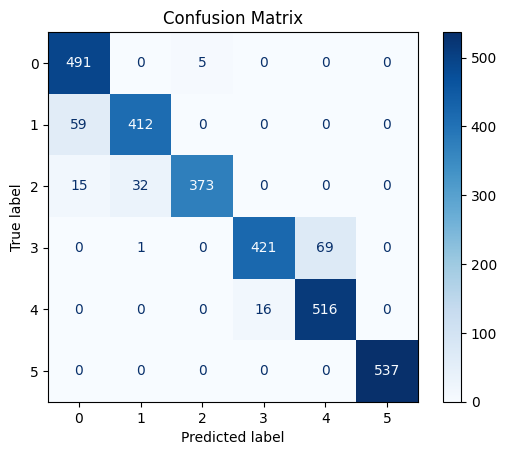

AUC Scores (per class): [0.99853417 0.99556164 0.99646673 0.99507586 0.99600476 1.        ]
Mean AUC: 0.9969


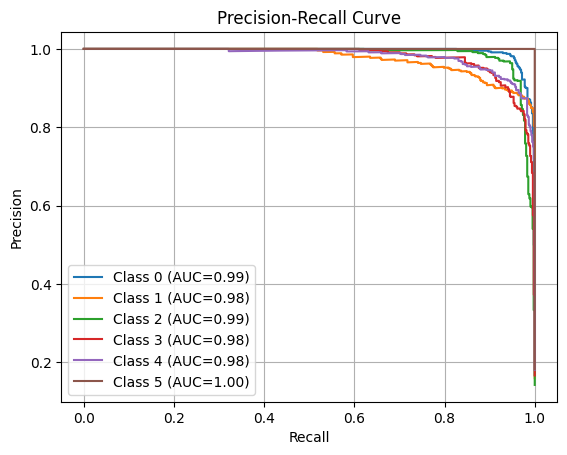

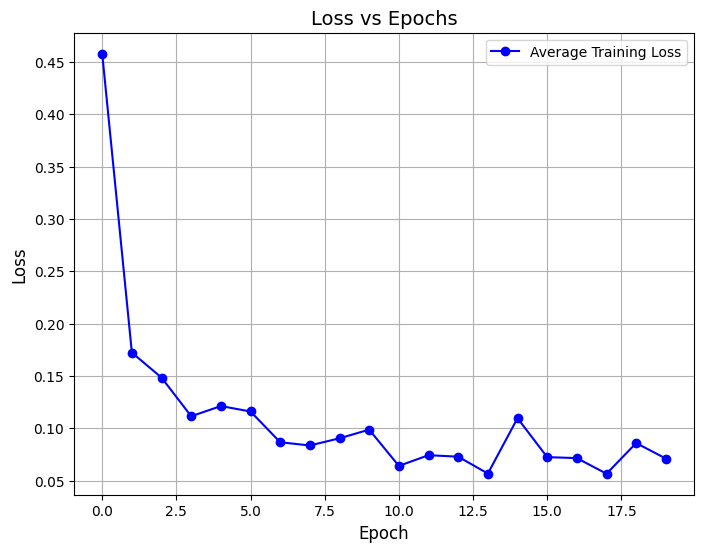

In [10]:
final_model = LSTMNet(input_size, hidden_size, num_layers, num_classes)
train_losses = train(train_set, final_model, criterion, epochs=20, lr=best_lr, print_epoch=True)
test(test_set, final_model)

# 绘制损失曲线
plot_loss(train_losses)